# Procesamiento
Vamos a utilizar sklearn para el procesamiento de datos mediante pipelines.
- Buena info de cómo hacer esto aquí: https://www.youtube.com/watch?v=0B5eIE_1vpU&t=1227s

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

train = pd.read_csv('../data/train_data.csv')
test = pd.read_csv('../data/test_data.csv')

In [2]:
# Vamos a definir los datos de entrenamiento
X = train.drop(['mineralType', 'id'], axis=1)
y = train['mineralType']

In [3]:
# Create sklearn pipeline for data preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, recall_score, precision_score
from sklearn import set_config
import numpy as np
import mlflow

mlflow.sklearn.autolog()
mlflow.set_experiment("knnclassifier")

preprocessor = ColumnTransformer([
        # (name, transformer, columns)
        ("temperatureFirstHalfPlanetRotation", make_pipeline(FunctionTransformer(lambda f: (f - 32) / 1.8, feature_names_out="one-to-one"), StandardScaler()), ['temperatureFirstHalfPlanetRotation']), # convert from Fahrenheit to Celsius
        ("temperatureSecondHalfPlanetRotation", StandardScaler(), ['temperatureSecondHalfPlanetRotation']), # pass through the column unchanged
        ("waterStreamDistanceX", make_pipeline(FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), StandardScaler()), ['waterStreamDistanceX']), # convert from feet to meters
        ("waterStreamDistanceY", StandardScaler(), ['waterStreamDistanceY']), # pass through the column unchanged
        ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']), # one-hot encode the planetSection column
        ("cover", OneHotEncoder(handle_unknown='error', drop='first'), ['cover']), # one-hot encode the cover column and drop the first column (the one with the missing values == 0)
        ("climaticZone", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ['climaticZone']), # ordinal encode the climaticZone column TODO: drop category 3? what to do? only one row has a 3
        ("geoZone", OneHotEncoder(handle_unknown = "ignore"), ['geoZone']), # one-hot encode the geoZone column TODO: drop category 5?
        ("rockSize", OneHotEncoder(handle_unknown='ignore', drop='first'), ['rockSize']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0)
        ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0) TODO: use Ordinal Encoder?
        ("mineralDensity", StandardScaler(), ['mineralDensity']), # pass through the column unchanged
        ("detectionDepth", StandardScaler(), ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
        ("longitude", StandardScaler(), ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
    ],
    verbose_feature_names_out=False, remainder='passthrough'
)

model = KNeighborsClassifier()
# model = LinearSVC(random_state=0, tol=1e-05)

grid = GridSearchCV(model, cv=5, scoring=['accuracy', 'precision_macro'], error_score='raise', return_train_score=True, n_jobs=-1, verbose=1, refit='accuracy',
            param_grid={
                'n_neighbors': [5, 8, 10, 12, 15, 20],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
                })

# pipe = Pipeline([
#     ('preprocessor', preprocessor),
#     ('grid', grid)
# ])

# Train the model
grid.fit(preprocessor.fit_transform(X, y), y)

set_config(display='diagram')
grid

2022/04/22 19:24:55 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/04/22 19:24:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '395f38274418417a86e2cf1941d6b2b2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/04/22 19:24:55 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2022/04/22 19:25:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ff4656c4a3fd4b5ba0f2264aca325d7f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/04/22 19:25:00 WARNING mlflow.sklearn: Failed to in

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2022/04/22 19:29:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/sergio/.pyenv/versions/3.7.13/envs/fase6/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2022/04/22 19:29:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/sergio/.pyenv/versions/3.7.13/envs/fase6/lib/python3.7/site-packages/mlflow/sklearn/utils.py:704: UserWarning: Top 5 child runs will be created based on ordering in rank_test_accuracy column. You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2022/04/22 19:29:31 INFO mlflow.sklearn.utils: Logging the 5 best runs, 19 runs will be omitted.


GridSearchCV(cv=5, error_score='raise', estimator=KNeighborsClassifier(),
             n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [5, 8, 10, 12, 15, 20],
                         'weights': ['uniform', 'distance']},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision_macro'], verbose=1)

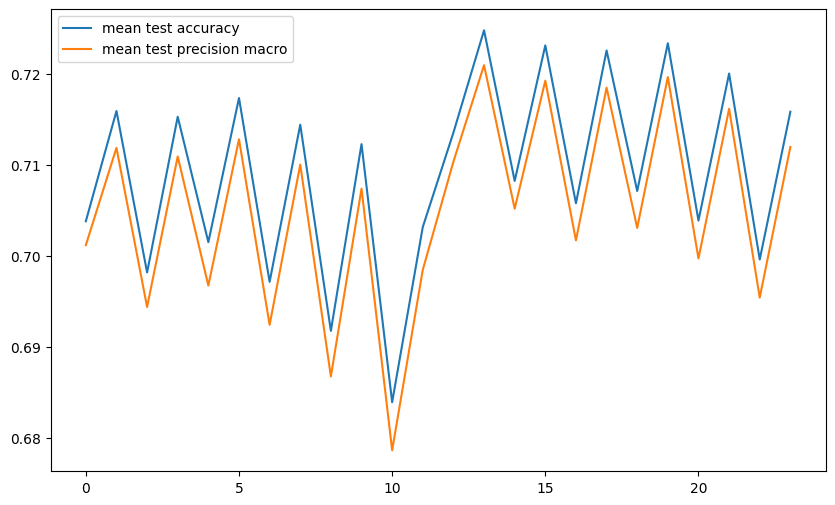

In [9]:
# Plot the results of the grid search to see which parameters are the best for the model to use
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(grid.cv_results_['mean_test_accuracy'], label='mean test accuracy')
plt.plot(grid.cv_results_['mean_test_precision_macro'], label='mean test precision macro')
plt.legend()
plt.show()

In [10]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [11]:
grid.best_score_

0.7248239632204106

In [13]:
# Sort grid results by ranking
grid_results_df = pd.DataFrame(grid.cv_results_)
grid_results_df.sort_values(by=['rank_test_accuracy'], ascending=True, inplace=True)

grid_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision_macro,split1_test_precision_macro,split2_test_precision_macro,split3_test_precision_macro,split4_test_precision_macro,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro,split0_train_precision_macro,split1_train_precision_macro,split2_train_precision_macro,split3_train_precision_macro,split4_train_precision_macro,mean_train_precision_macro,std_train_precision_macro
13,0.012901,0.010348,3.079559,0.590517,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.721584,0.728605,0.711569,0.723455,0.738906,0.724824,0.008952,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.718167,0.724020,0.708098,0.718437,0.736211,0.720987,0.009182,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
19,0.014837,0.007488,3.144923,0.127650,manhattan,12,distance,"{'metric': 'manhattan', 'n_neighbors': 12, 'we...",0.715248,0.720681,0.719097,0.729398,0.732567,0.723398,0.006517,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.712287,0.716175,0.715133,0.724392,0.730421,0.719681,0.006711,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
15,0.016125,0.012359,4.224793,0.704155,manhattan,8,distance,"{'metric': 'manhattan', 'n_neighbors': 8, 'wei...",0.712079,0.721078,0.715927,0.730190,0.736529,0.723161,0.009029,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.708269,0.716473,0.712550,0.725139,0.733982,0.719282,0.009218,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
17,0.042495,0.014988,7.861401,1.209663,manhattan,10,distance,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.716832,0.718304,0.714342,0.730983,0.732567,0.722606,0.007610,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.713957,0.713515,0.709528,0.726068,0.729510,0.718516,0.007804,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
21,0.018649,0.015275,2.785493,0.314120,manhattan,15,distance,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",0.709703,0.716719,0.713154,0.730586,0.730190,0.720071,0.008713,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.706898,0.711948,0.708526,0.725246,0.728342,0.716192,0.008863,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.020916,0.011649,0.912224,0.146517,euclidean,10,distance,"{'metric': 'euclidean', 'n_neighbors': 10, 'we...",0.708911,0.718700,0.713946,0.717512,0.727813,0.717376,0.006231,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.705148,0.714850,0.709022,0.711306,0.723898,0.712845,0.006363,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.035172,0.011127,1.460177,0.282544,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.714455,0.715927,0.713154,0.706418,0.729794,0.715950,0.007649,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.710701,0.711313,0.710378,0.700629,0.726476,0.711900,0.008290,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
23,0.008970,0.002245,3.331275,0.245283,manhattan,20,distance,"{'metric': 'manhattan', 'n_neighbors': 20, 'we...",0.706931,0.707607,0.712361,0.724247,0.728209,0.715871,0.008751,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.704111,0.702049,0.708347,0.718801,0.726704,0.712003,0.009349,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.052925,0.020648,1.825995,0.449692,euclidean,8,distance,"{'metric': 'euclidean', 'n_neighbors': 8, 'wei...",0.710891,0.712758,0.709984,0.715135,0.727813,0.715316,0.006492,9,1.000000,1.000000,1.000000,1.000000,1.000

In [8]:
# preprocessed_data = preprocessor.fit_transform(X)

# preprocessed_dataframe = pd.DataFrame(preprocessed_data, columns=preprocessor.get_feature_names_out())
# preprocessed_dataframe